# Correlation analysis

## 1. Preprocessing

In [1]:
%%capture
%run preprocessing.ipynb

### 1.1 Select relevant data

In [2]:
# filter relevant timeframe
merged_df = merged_df.query('1995 <= year <= 2024')

# exclude irrelevant variables
merged_df = merged_df.drop(columns = ['f_unemployment', 
                            'm_unemployment', 
                            'Tertiary education (levels 5-8)',
                            'Upper secondary and post-secondary non-tertiary education (levels 3 and 4)'])

### 1.2 Combine with fragmentation and polarization index

In [3]:
# deduplicate: if in a year there were 2 elections, keep the first one
elections_dedup = elections.reset_index().sort_values('election_date').drop_duplicates(
    subset=['geo', 'election_year'], keep='first'
)

merged_df = merged_df.reset_index().sort_values('election_date').drop_duplicates(
    subset=['geo', 'year', 'party_code'], keep='first'
).set_index(['geo', 'year'])

# remove party 34020 (SYRIZA) for years >= 2012 (it merged into 34212)
merged_df = merged_df.reset_index()
merged_df = merged_df[~((merged_df['geo'] == 'GR') & 
                        (merged_df['year'] >= 2012) & 
                        (merged_df['party_code'] == 34020))]
merged_df = merged_df.set_index(['geo', 'year'])

df_correlations = pd.merge(
    left=merged_df.reset_index(),
    right=elections_dedup,
    how='left',
    left_on=['geo', 'year'],
    right_on=['geo', 'election_year']
).set_index(['geo', 'year'])

# df_correlations

### 1.3 Imputation

In [4]:
# imputation of missing values in demographic/socioeconomic variables
socioeco_vars = [
    'total_poverty', 'gdp_per_cap', 'consumer_prices','t_unemployment', 
    'dependency_ratio_15_64', 'debt_to_gdp',
    'Less than primary, primary and lower secondary education (levels 0-2)',
    'Upper secondary, post-secondary non-tertiary and tertiary education (levels 3-8)',
    'migration_inflow', 'median_age', 'population_total',
    'urban_population_pct', 'wealth_top10_share'
]

missings_check = df_correlations.groupby(['geo', 'year'])[socioeco_vars].mean()

for geo in sorted(missings_check.index.get_level_values('geo').unique()):
    subset = missings_check.loc[geo]
    missing_rows = subset[subset.isna().any(axis=1)]
    if len(missing_rows) > 0:
        print(f"\n{geo}:")
        for year in missing_rows.index:
            missing_vars = missing_rows.loc[year][missing_rows.loc[year].isna()].index.tolist()
            print(f"  {year}: {missing_vars}")


AT:
  1995: ['consumer_prices', 'migration_inflow']
  2000: ['Less than primary, primary and lower secondary education (levels 0-2)', 'Upper secondary, post-secondary non-tertiary and tertiary education (levels 3-8)']
  2001: ['Less than primary, primary and lower secondary education (levels 0-2)', 'Upper secondary, post-secondary non-tertiary and tertiary education (levels 3-8)']
  2002: ['total_poverty', 'Less than primary, primary and lower secondary education (levels 0-2)', 'Upper secondary, post-secondary non-tertiary and tertiary education (levels 3-8)']
  2003: ['Less than primary, primary and lower secondary education (levels 0-2)', 'Upper secondary, post-secondary non-tertiary and tertiary education (levels 3-8)']
  2024: ['gdp_per_cap', 'migration_inflow', 'urban_population_pct']

BE:
  1995: ['consumer_prices']
  2002: ['total_poverty']
  2008: ['migration_inflow']
  2009: ['migration_inflow']
  2024: ['gdp_per_cap', 'migration_inflow', 'urban_population_pct']

BG:
  1995: 

In [5]:
# create dataset only with country-year combinations
country_year_data = df_correlations.reset_index().groupby(['geo', 'year'])[socioeco_vars].first().reset_index()

# sort and interpolate at country level
country_year_data = country_year_data.sort_values(['geo', 'year'])

country_year_data[socioeco_vars] = country_year_data.groupby('geo')[socioeco_vars].transform(
    lambda x: x.interpolate(method='linear', limit_area='inside', limit=4)
)

# extrapolate
country_year_data[socioeco_vars] = country_year_data.groupby('geo')[socioeco_vars].transform(
    lambda x: x.interpolate(method='linear', limit_area='outside', limit=2, limit_direction='both')
)

# check missings
for geo in sorted(country_year_data['geo'].unique()):
    subset = country_year_data[country_year_data['geo'] == geo]
    missing_rows = subset[subset[socioeco_vars].isna().any(axis=1)]
    if len(missing_rows) > 0:
        print(f"\n{geo}:")
        for _, row in missing_rows.iterrows():
            missing_vars = [v for v in socioeco_vars if pd.isna(row[v])]
            print(f"  {int(row['year'])}: {missing_vars}")


BG:
  1995: ['total_poverty', 't_unemployment', 'Less than primary, primary and lower secondary education (levels 0-2)', 'Upper secondary, post-secondary non-tertiary and tertiary education (levels 3-8)', 'migration_inflow']
  1996: ['total_poverty', 't_unemployment', 'Less than primary, primary and lower secondary education (levels 0-2)', 'Upper secondary, post-secondary non-tertiary and tertiary education (levels 3-8)', 'migration_inflow']
  1997: ['total_poverty', 't_unemployment', 'Less than primary, primary and lower secondary education (levels 0-2)', 'Upper secondary, post-secondary non-tertiary and tertiary education (levels 3-8)', 'migration_inflow']
  1998: ['migration_inflow']
  1999: ['migration_inflow']
  2000: ['migration_inflow']
  2001: ['migration_inflow']
  2002: ['migration_inflow']
  2003: ['migration_inflow']
  2004: ['migration_inflow']

CY:
  1996: ['total_poverty', 't_unemployment', 'Less than primary, primary and lower secondary education (levels 0-2)', 'Upper 

In [6]:
# merge back
df_correlations = df_correlations.reset_index()
df_correlations = df_correlations.drop(columns=socioeco_vars)
df_correlations = pd.merge(df_correlations, country_year_data, on=['geo', 'year'], how='left')

### 1.4 Checks

In [7]:
# Plausibility of values
vote_sums = df_correlations.groupby(['geo', 'year'])['vote_share_percent'].sum().reset_index()
vote_sums.columns = ['geo', 'year', 'total_vote_share']

# Check if any are far from 100
print(vote_sums[vote_sums['total_vote_share'] > 100])  

# if empty, no duplicates

Empty DataFrame
Columns: [geo, year, total_vote_share]
Index: []


# 2. Correlation analysis

## 2.1 Correlation heatmap
As a first step, we look at the correlations between relevant country characterstics and election outcomes, polarization and fragmentation. To avoid artificial underestimation of standard errors, we aggregate the yearly observations to inter-election intervals. Socioeconomic variables are aggregated by mean of the years leading up to an election.

In [ ]:
vs_vars = [col for col in df_correlations.columns if col.startswith('vs_')]
df_correlations = df_correlations.sort_values(['country', 'year'])

# extract election year and month
df_correlations['election_year'] = pd.to_datetime(df_correlations['election_date_x']).dt.year
df_correlations['election_month'] = pd.to_datetime(df_correlations['election_date_x']).dt.month

# For each row, determine which election this year's data should predict
def assign_target_election(group):
    group = group.sort_values('year')
    
    # Get unique elections with their dates and months
    elections = (group[['election_date_x', 'election_year', 'election_month']]
                 .drop_duplicates()
                 .sort_values('election_year')
                 .reset_index(drop=True))
    
    def find_target(year):
        for i, row in elections.iterrows():
            e_year = row['election_year']
            e_month = row['election_month']
            
            if year < e_year:
                # Year is before election year: belongs to this election
                return row['election_date_x']
            elif year == e_year and e_month >= 7:
                # Year equals election year AND election is in second half: belongs to this election
                return row['election_date_x']
        
        return None  # Year is after all elections
    
    group['target_election'] = group['year'].apply(find_target)
    return group

df_correlations = df_correlations.groupby('country', group_keys=False).apply(assign_target_election)

df_for_agg = df_correlations.dropna(subset=['target_election'])
df_averaged = df_for_agg.groupby(['country', 'target_election']).agg({
    'fragmentation_enp': 'first',
    'polarization_dalton': 'first',
    **{var: 'first' for var in vs_vars},
    **{var: 'mean' for var in socioeco_vars}
}).reset_index()

/var/folders/72/4mfr23zn6rl6yvskrt7mr9tc0000gn/T/ipykernel_20325/277056934.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_correlations = df_correlations.groupby('country', group_keys=False).apply(assign_target_election)


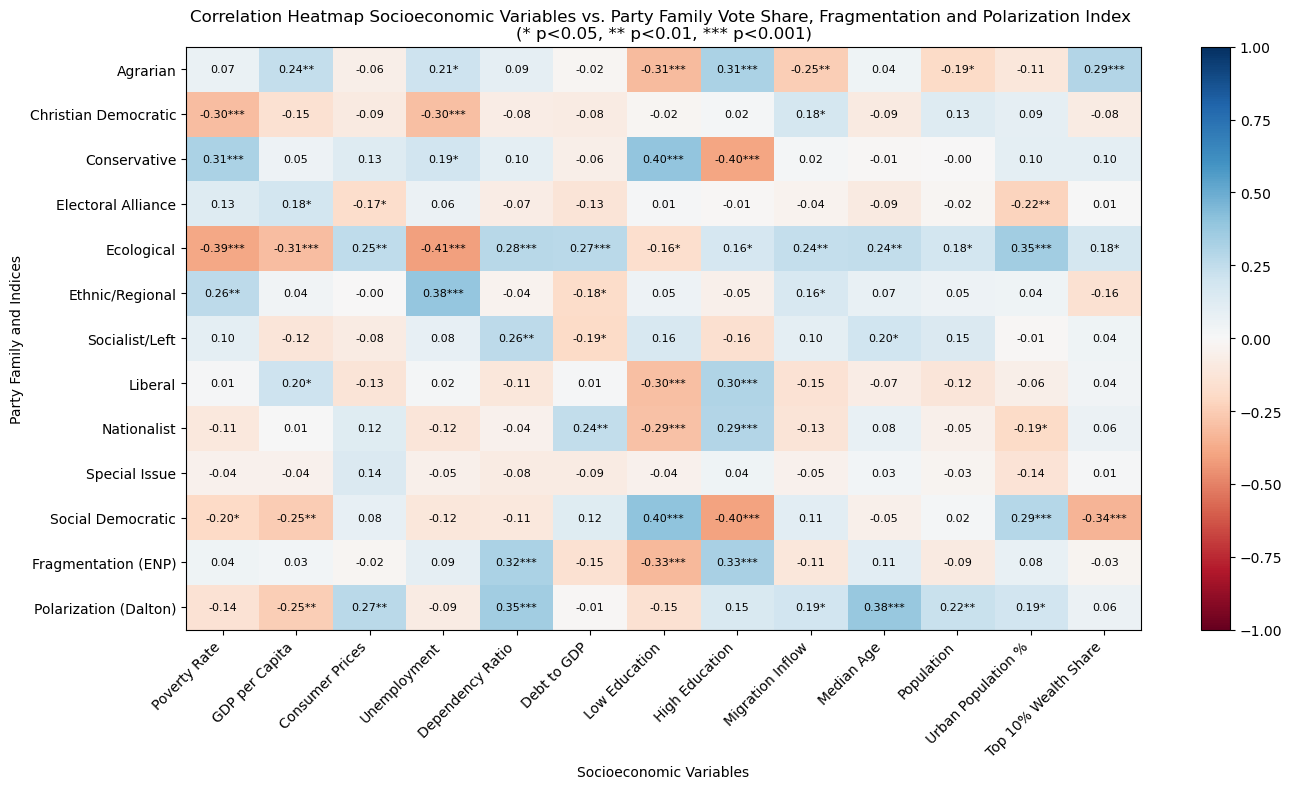

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Party family vote share columns
vs_cols = [col for col in df_averaged.columns if col.startswith('vs_')] + ['fragmentation_enp', 'polarization_dalton']

# calculate correlations and p-values
corr_matrix = []
pval_matrix = []

for vs_col in vs_cols:
    corr_row = []
    pval_row = []
    for socio_col in socioeco_vars:
        # Drop NaN values for both columns
        valid_data = df_averaged[[vs_col, socio_col]].dropna()
        if len(valid_data) > 2:
            corr, pval = stats.pearsonr(valid_data[vs_col], valid_data[socio_col])
        else:
            corr, pval = np.nan, np.nan
        corr_row.append(corr)
        pval_row.append(pval)
    corr_matrix.append(corr_row)
    pval_matrix.append(pval_row)

corr_df = pd.DataFrame(corr_matrix, index=vs_cols, columns=socioeco_vars)
pval_df = pd.DataFrame(pval_matrix, index=vs_cols, columns=socioeco_vars)

# Labels
parfam_labels = {
    'vs_SOC': 'Social Democratic',
    'vs_LEF': 'Socialist/Left',
    'vs_ECO': 'Ecological',
    'vs_LIB': 'Liberal',
    'vs_CHR': 'Christian Democratic',
    'vs_CON': 'Conservative',
    'vs_NAT': 'Nationalist',
    'vs_AGR': 'Agrarian',
    'vs_ETH': 'Ethnic/Regional',
    'vs_SIP': 'Special Issue',
    'vs_DIV': 'Electoral Alliance',
    'fragmentation_enp': 'Fragmentation (ENP)',
    'polarization_dalton': 'Polarization (Dalton)'
}

var_labels = {
    'total_poverty': 'Poverty Rate',
    'gdp_per_cap': 'GDP per Capita',
    'consumer_prices': 'Consumer Prices',
    't_unemployment': 'Unemployment',
    'dependency_ratio_15_64': 'Dependency Ratio',
    'debt_to_gdp': 'Debt to GDP',
    'Less than primary, primary and lower secondary education (levels 0-2)': 'Low Education',
    'Upper secondary, post-secondary non-tertiary and tertiary education (levels 3-8)': 'High Education',
    'migration_inflow': 'Migration Inflow',
    'median_age': 'Median Age',
    'population_total': 'Population',
    'urban_population_pct': 'Urban Population %',
    'wealth_top10_share': 'Top 10% Wealth Share'
}

# Apply labels
corr_df.index = corr_df.index.map(lambda x: parfam_labels.get(x, x))
corr_df.columns = corr_df.columns.map(lambda x: var_labels.get(x, x))
pval_df.index = pval_df.index.map(lambda x: parfam_labels.get(x, x))
pval_df.columns = pval_df.columns.map(lambda x: var_labels.get(x, x))

# Create heatmap
fig, ax = plt.subplots(figsize=(14, 8))

im = ax.imshow(corr_df.values, cmap='RdBu', vmin=-1, vmax=1, aspect='auto')
cbar = plt.colorbar(im)

ax.set_xticks(np.arange(len(corr_df.columns)))
ax.set_yticks(np.arange(len(corr_df.index)))
ax.set_xticklabels(corr_df.columns, rotation=45, ha='right')
ax.set_yticklabels(corr_df.index)

## Add correlation values and significance markers
for i in range(len(corr_df.index)):
    for j in range(len(corr_df.columns)):
        val = corr_df.iloc[i, j]
        pval = pval_df.iloc[i, j]
        color = 'white' if abs(val) > 0.5 else 'black'
        
        # Add stars for significance
        if pval < 0.001:
            stars = '***'
        elif pval < 0.01:
            stars = '**'
        elif pval < 0.05:
            stars = '*'
        else:
            stars = ''
        
        ax.text(j, i, f'{val:.2f}{stars}', ha='center', va='center', color=color, fontsize=8)

ax.set_title('Correlation Heatmap Socioeconomic Variables vs. Party Family Vote Share, Fragmentation and Polarization Index \n(* p<0.05, ** p<0.01, *** p<0.001)')
ax.set_xlabel('Socioeconomic Variables')
ax.set_ylabel('Party Family and Indices')

plt.tight_layout()
plt.show()

In [13]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import statsmodels.api as sm

dependent_vars = [col for col in df_averaged.columns if col.startswith('vs_')] + ['fragmentation_enp', 'polarization_dalton']

# avoid multicolinearity on education variables
socioeco_vars = [var for var in socioeco_vars if var != "Less than primary, primary and lower secondary education (levels 0-2)"]

def run_regression(dependent_var):
    clear_output(wait=True)
    
    # prep
    reg_data = df_averaged[[dependent_var] + socioeco_vars].dropna()
    
    X = reg_data[socioeco_vars]
    y = reg_data[dependent_var]
    
    # standardize (to make effectsizes comparable)
    X_standardized = (X - X.mean()) / X.std()
    X_standardized = sm.add_constant(X_standardized)
    
    # OLS
    model = sm.OLS(y, X_standardized).fit()
    
    # Display results
    dep_label = parfam_labels.get(dependent_var, dependent_var)
    print(f"=" * 80)
    print(f"OLS Regression: {dep_label}")
    print(f"=" * 80)
    print(f"Observations: {int(model.nobs)}")
    print(f"R-squared: {model.rsquared:.3f}")
    print(f"Adj. R-squared: {model.rsquared_adj:.3f}")
    print(f"\n{'Variable':<45} {'Coef':>10} {'Std Err':>10} {'t':>8} {'P>|t|':>8} {'Sig':>5}")
    print("-" * 90)
    
    # sor results by absolute coefficient (importance)
    results = []
    for var in socioeco_vars:
        label = var_labels.get(var, var)
        coef = model.params[var]
        std_err = model.bse[var]
        t_val = model.tvalues[var]
        p_val = model.pvalues[var]
        
        if p_val < 0.001:
            sig = '***'
        elif p_val < 0.01:
            sig = '**'
        elif p_val < 0.05:
            sig = '*'
        else:
            sig = ''
        
        results.append((label, coef, std_err, t_val, p_val, sig, abs(coef)))
    
    results.sort(key=lambda x: x[6], reverse=True)
    
    for label, coef, std_err, t_val, p_val, sig, _ in results:
        print(f"{label:<45} {coef:>10.3f} {std_err:>10.3f} {t_val:>8.2f} {p_val:>8.3f} {sig:>5}")
    
    print("-" * 90)
    print("* p<0.05, ** p<0.01, *** p<0.001")
    print("Note: Coefficients are standardized (beta coefficients)")
    
    # # plot coefficients
    # fig, ax = plt.subplots(figsize=(10, 6))
    
    # labels = [r[0] for r in results]
    # coefs = [r[1] for r in results]
    # errors = [1.96 * r[2] for r in results]  # 95% CI
    # colors = ['blue' if c > 0 else 'red' for c in coefs]
    # significant = [r[4] < 0.05 for r in results]
    
    # y_pos = np.arange(len(labels))
    
    # bars = ax.barh(y_pos, coefs, xerr=errors, color=colors, alpha=0.7, capsize=3)
    
    # ax.set_yticks(y_pos)
    # ax.set_yticklabels(labels)
    # ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    # ax.set_xlabel('Standardized Coefficient (with 95% CI)')
    # ax.set_title(f'Predictors of {dep_label}\n(Black border = p<0.05)')
    
    # plt.tight_layout()
    # plt.show()

# Create dropdown
dropdown = widgets.Dropdown(
    options=[(parfam_labels.get(v, v), v) for v in dependent_vars],
    value=dependent_vars[0],
    description='Dependent:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)

# Create interactive output
output = widgets.interactive_output(run_regression, {'dependent_var': dropdown})

display(dropdown, output)

Dropdown(description='Dependent:', layout=Layout(width='300px'), options=(('Agrarian', 'vs_AGR'), ('Christian …

Output()